<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/t5/661_T5_CARER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 CARER

This notebook will fine-tune a pretrained T5 model on the Contextualized Affect Representations for Emotion Recognition (CARER) dataset. The performance of the model will serve as one of the baselines with which to compare the performances of the autoregressive models on text classification.

## Setup

In [1]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from transformers import T5TokenizerFast, T5ForConditionalGeneration, T5ForSequenceClassification#, AdamW
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from time import time

In [3]:
cuda = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
model_size = 'base'

## Dataset

In [5]:
dataset = load_dataset("dair-ai/emotion", "split")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [6]:
for i, val in enumerate(dataset['train']):
    print(val)
    if i == 10:
        break

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}
{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}
{'text': 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'label': 2}
{'text': 'i am feeling grouchy', 'label': 3}
{'text': 'ive been feeling a little burdened lately wasnt sure why that was', 'label': 0}
{'text': 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny', 'label': 5}
{'text': 'i feel as confused about life as a teenager or as jaded as a year old man', 'label': 4}
{'text': 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'label': 1}
{'text': 'i feel romantic too', 'label': 2}
{'text': 'i feel like i have to make the suffering i m seeing mean something', 'la

## T5 Sequence Classification

Performance of sequence classification will be used merely as a comparison to text generation.

In [7]:
tokenizer = T5TokenizerFast.from_pretrained(f't5-{model_size}')

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
def tokenize_data(data):
  return tokenizer(
      data["text"],
      padding="max_length",
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )

In [11]:
tokenized_dataset = dataset.map(tokenize_data, batched=True)
print(tokenized_dataset)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [12]:
for i, val in enumerate(tokenized_dataset['train']):
    print(val)
    if i == 10:
        break

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [3, 23, 737, 17, 473, 30880, 15, 26, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0, 'inp

In [22]:
lengths = []
for i, val in enumerate(tokenized_dataset['train']):
  input_ids = val["input_ids"]
  no_pad = [token for token in input_ids if token != 0]
  lengths.append(len(no_pad))
lengths = np.array(lengths)
print(lengths.mean(), lengths.max(), lengths.min())

24.8685 107 3


In [23]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### Dataset split

In [24]:
train_ds = tokenized_dataset["train"]
val_ds = tokenized_dataset["validation"]
test_ds = tokenized_dataset["test"]

In [26]:
for i, val in enumerate(test_ds):
    print(val['label'])
    if i == 10:
        break

tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(4)
tensor(3)
tensor(1)
tensor(1)
tensor(3)
tensor(4)


In [27]:
unique, counts = np.unique(train_ds['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 4666, 1: 5362, 2: 1304, 3: 2159, 4: 1937, 5: 572}


In [28]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [48]:
model = T5ForSequenceClassification.from_pretrained(f"t5-{model_size}", num_labels=len(unique))
model.to(cuda)
print(model)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [49]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [50]:
len(train_loader)

500

In [51]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = loss_fn(outputs.logits.squeeze(), labels)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval - 1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_loader:
      input_ids = batch["input_ids"].to(cuda)
      attention_mask = batch["attention_mask"].to(cuda)
      labels = batch["label"].to(cuda)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      preds = torch.argmax(outputs.logits, dim=1)
      total += labels.size(0)
      correct += (preds == labels).sum().item()
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")
print("Training finished")

Epoch 1/5, Batch 100/500, Loss: 1.678
Time elapsed: 38.145s
Epoch 1/5, Batch 200/500, Loss: 1.571
Time elapsed: 76.234s
Epoch 1/5, Batch 300/500, Loss: 1.555
Time elapsed: 114.366s
Epoch 1/5, Batch 400/500, Loss: 1.474
Time elapsed: 152.518s
Epoch 1/5, Batch 500/500, Loss: 1.401
Time elapsed: 190.668s
Epoch 1/5, Validation Accuracy: 0.544
Epoch 2/5, Batch 100/500, Loss: 1.156
Time elapsed: 235.492s
Epoch 2/5, Batch 200/500, Loss: 0.975
Time elapsed: 272.682s
Epoch 2/5, Batch 300/500, Loss: 0.862
Time elapsed: 309.919s
Epoch 2/5, Batch 400/500, Loss: 0.750
Time elapsed: 347.118s
Epoch 2/5, Batch 500/500, Loss: 0.621
Time elapsed: 384.312s
Epoch 2/5, Validation Accuracy: 0.801
Epoch 3/5, Batch 100/500, Loss: 0.487
Time elapsed: 429.123s
Epoch 3/5, Batch 200/500, Loss: 0.415
Time elapsed: 466.341s
Epoch 3/5, Batch 300/500, Loss: 0.379
Time elapsed: 503.549s
Epoch 3/5, Batch 400/500, Loss: 0.340
Time elapsed: 540.812s
Epoch 3/5, Batch 500/500, Loss: 0.317
Time elapsed: 578.008s
Epoch 3/5, 

### Inference

In [52]:
model.eval()
with torch.no_grad():
  all_preds = []
  all_labels = []
  for batch in test_loader:
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # take the highest-probability class for multiclass prediction
    preds = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       581
           1       0.92      0.93      0.92       695
           2       0.76      0.77      0.77       159
           3       0.96      0.87      0.91       275
           4       0.86      0.89      0.87       224
           5       0.72      0.65      0.68        66

    accuracy                           0.90      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.90      0.90      0.90      2000



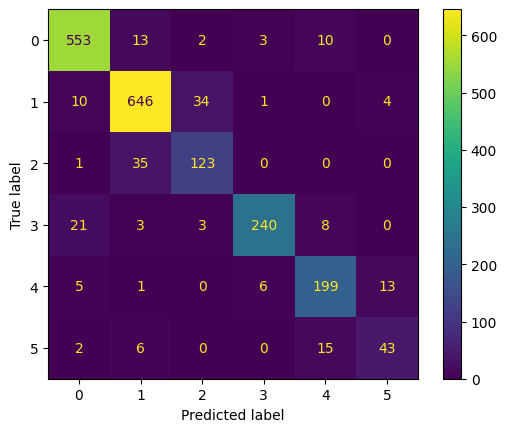

In [53]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [54]:
torch.save(model.state_dict(), f"t5-{model_size}-emotion-classification.pt")

In [58]:
from google.colab import files
files.download(f"t5-{model_size}-emotion-classification.pt")
print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started


## T5 Conditional Generation

Performance of conditional generation will be measured as a baseline performance, as the task more closely resembles the task of sentiment generation for the autoregressive models.

In [59]:
torch.cuda.empty_cache()

### Tokenizer

In [60]:
prefix = "Classify the emotion of the following text: "
train_ds = dataset["train"]
val_ds = dataset["validation"]
test_ds = dataset["test"]
train_ds = train_ds.map(lambda x: {"text": prefix + x["text"]})
val_ds = val_ds.map(lambda x: {"text": prefix + x["text"]})
test_ds = test_ds.map(lambda x: {"text": prefix + x["text"]})

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [61]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def map_labels(data):
  data["emotion"] = label_map[data["label"]]
  return data

train_ds = train_ds.map(map_labels)
val_ds = val_ds.map(map_labels)
test_ds = test_ds.map(map_labels)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [62]:
for i, val in enumerate(train_ds):
    print(val)
    if i == 10:
        break

{'text': 'Classify the emotion of the following text: i didnt feel humiliated', 'label': 0, 'emotion': 'sadness'}
{'text': 'Classify the emotion of the following text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0, 'emotion': 'sadness'}
{'text': 'Classify the emotion of the following text: im grabbing a minute to post i feel greedy wrong', 'label': 3, 'emotion': 'anger'}
{'text': 'Classify the emotion of the following text: i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'label': 2, 'emotion': 'love'}
{'text': 'Classify the emotion of the following text: i am feeling grouchy', 'label': 3, 'emotion': 'anger'}
{'text': 'Classify the emotion of the following text: ive been feeling a little burdened lately wasnt sure why that was', 'label': 0, 'emotion': 'sadness'}
{'text': 'Classify the emotion of the following text: ive been taking or milligrams or times recommended 

In [78]:
def tokenize_data(data):
  inputs = tokenizer(
      data["text"],
      padding="max_length",
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )
  labels = tokenizer(
      data["emotion"],
      padding="max_length",
      truncation=True,
      max_length=2,
      return_tensors="pt"
  )
  inputs["label"] = labels["input_ids"]
  return inputs

In [79]:
train_tokenized = train_ds.map(tokenize_data, batched=True)
val_tokenized = val_ds.map(tokenize_data, batched=True)
test_tokenized = test_ds.map(tokenize_data, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [80]:
for i, val in enumerate(train_tokenized):
    print(val)
    if i == 10:
        break

{'text': 'Classify the emotion of the following text: i didnt feel humiliated', 'label': [24784, 1], 'emotion': 'sadness', 'input_ids': [4501, 4921, 8, 13868, 13, 8, 826, 1499, 10, 3, 23, 737, 17, 473, 30880, 15, 26, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'text': 'Classify the emotion of the followi

In [82]:
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [83]:
unique, counts = np.unique(train_tokenized['label'], return_counts=True)
print(dict(zip(unique, counts)))

{1: 16000, 333: 1304, 2971: 1937, 3922: 5362, 4158: 572, 11213: 2159, 24784: 4666}


In [84]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_tokenized, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [89]:
model = T5ForConditionalGeneration.from_pretrained(f"t5-{model_size}")
model.to(cuda)
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [90]:
epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-4)

In [91]:
emotion_map = dict(zip(label_map.values(), label_map.keys()))
emotion_map

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [92]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
print("Training started")
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval-1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    all_texts = []
    all_preds = []
    all_labels = []
    for batch in test_loader:
      input_ids = batch["input_ids"].to(cuda)
      attention_mask = batch["attention_mask"].to(cuda)
      outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=8)
      preds = [emotion_map[pred] for pred in tokenizer.batch_decode(outputs, skip_special_tokens=True)]
      labels = [emotion_map[label] for label in tokenizer.batch_decode(batch["label"], skip_special_tokens=True)]
      total += len(labels)
      correct += (np.array(preds) == np.array(labels)).sum()
    print(f"Epoch {epoch+1}/{epochs}, Validation Accuracy: {correct / total:.3f}")

print("Training finished")

Training started
Epoch 1/3, Batch 100/500, Loss: 1.147
Time elapsed: 21.393s
Epoch 1/3, Batch 200/500, Loss: 0.370
Time elapsed: 42.587s
Epoch 1/3, Batch 300/500, Loss: 0.287
Time elapsed: 63.737s
Epoch 1/3, Batch 400/500, Loss: 0.222
Time elapsed: 84.998s
Epoch 1/3, Batch 500/500, Loss: 0.177
Time elapsed: 106.132s
Epoch 1/3, Validation Accuracy: 0.913
Epoch 2/3, Batch 100/500, Loss: 0.085
Time elapsed: 132.153s
Epoch 2/3, Batch 200/500, Loss: 0.082
Time elapsed: 152.724s
Epoch 2/3, Batch 300/500, Loss: 0.079
Time elapsed: 173.268s
Epoch 2/3, Batch 400/500, Loss: 0.075
Time elapsed: 193.812s
Epoch 2/3, Batch 500/500, Loss: 0.065
Time elapsed: 214.384s
Epoch 2/3, Validation Accuracy: 0.929
Epoch 3/3, Batch 100/500, Loss: 0.046
Time elapsed: 240.366s
Epoch 3/3, Batch 200/500, Loss: 0.050
Time elapsed: 260.915s
Epoch 3/3, Batch 300/500, Loss: 0.049
Time elapsed: 281.483s
Epoch 3/3, Batch 400/500, Loss: 0.047
Time elapsed: 302.006s
Epoch 3/3, Batch 500/500, Loss: 0.048
Time elapsed: 322.5

### Inference

In [93]:
model.eval()
with torch.no_grad():
  all_texts = []
  all_preds = []
  all_labels = []
  for batch in test_loader:
    outputs = model.generate(input_ids=batch["input_ids"].to(cuda), attention_mask=batch["attention_mask"].to(cuda), max_length=8)
    all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
    all_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    all_labels.extend(tokenizer.batch_decode(batch["label"], skip_special_tokens=True))

In [94]:
for i in range(10):
  print("Sentence: " + all_texts[i])
  print("Predicted sentiment: " + all_preds[i])
  print("Actual sentiment: " + all_labels[i])

Sentence: Classify the emotion of the following text: im feeling rather rotten so im not very ambitious right now
Predicted sentiment: sadness
Actual sentiment: sadness
Sentence: Classify the emotion of the following text: im updating my blog because i feel shitty
Predicted sentiment: sadness
Actual sentiment: sadness
Sentence: Classify the emotion of the following text: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Predicted sentiment: sadness
Actual sentiment: sadness
Sentence: Classify the emotion of the following text: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
Predicted sentiment: joy
Actual sentiment: joy
Sentence: Classify the emotion of the following text: i was feeling a little vain when i did this one
Predicted sentiment: sadness
Actual sentiment: sadness
Sentence: Classify the emotion of the following text: i cant walk into a shop anywhere where i do not

In [95]:
preds = [emotion_map[pred] for pred in all_preds]
labels = [emotion_map[label] for label in all_labels]

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       581
           1       0.92      0.98      0.95       695
           2       0.94      0.69      0.79       159
           3       0.93      0.93      0.93       275
           4       0.95      0.84      0.89       224
           5       0.71      0.76      0.74        66

    accuracy                           0.93      2000
   macro avg       0.90      0.86      0.88      2000
weighted avg       0.93      0.93      0.93      2000



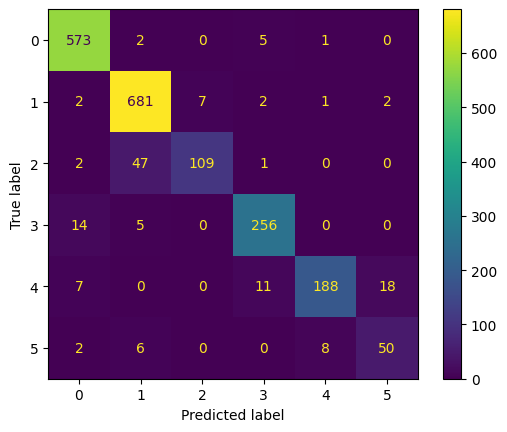

In [96]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The text generation model outperforms the sentiment classification model. As T5 was trained to generate output text from input text, it is better suited to treat this task as text generation rather than standard classification.

In [ ]:
torch.save(model.state_dict(), f"t5-{model_size}-emotion-generation.pt")

In [ ]:
files.download(f"t5-{model_size}-emotion-generation.pt")
print("Download started")